# Лаборная работа 3

### Задание 1

Рассматривается обратимая химическая реакция
$$
A \rightleftarrows B
$$

Обозначим через $C_A(t), C_B(t)$ - концентрации реагентов $A$ и $B$ в момент времени $t$. Пусть динамика изменения концентрации описывается следующей системой дифференциальных уравнений
$$
\begin{aligned}
\frac{d C_A}{d t} & =-k_1 C_A+k_2 C_B \\
\frac{d C_B}{d t} & =k_1 C_A-k_2 C_B
\end{aligned}
$$

с начальными условиями (предполагаются известными)
$$
C_A(0)=C_{A, 0}, \quad C_B(0)=C_{B, 0}
$$

В моменты времени $0<t_1<t_2<\cdots<t_n$ производится замер концентрации вещества $A: C_A\left(t_j\right), j=1, \ldots, n$. Требуется найти оценки неизвестных параметров $k_1, k_2$ в рамках следующей модели наблюдения:
$$
y_j=C_A\left(t_j\right)+e_j, \quad e_j \sim \mathcal{N}\left(0, \sigma^2\right)
$$

В файле data.txt записаны результаты измерения концентрации вещества $A$ на отрезке времени $[0,3]$, при этом частота дискретизации составляет 1 кГц. Расчеты произвести для следующих значений параметров: $C_{A, 0}=10 ; C_{B, 0}=15$; $\sigma=0,2$.

In [6]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Загрузка данных
data = np.loadtxt('./lab_files/data.txt')
y = data  # Измеренные значения концентрации C_A
t = np.linspace(0, 3, len(y))  # Временные точки (0 до 3 секунд с шагом 1 мс)

# Начальные условия
C_A0 = 10  # Начальная концентрация A
C_B0 = 15  # Начальная концентрация B
sigma = 0.2  # Стандартное отклонение ошибки измерений

# Функция для решения системы дифференциальных уравнений
def model(t, k1, k2):
    def dCdt(t, C, k1, k2):  # Добавляем k1 и k2 как аргументы
        dCA_dt = -k1 * C[0] + k2 * C[1]
        dCB_dt = k1 * C[0] - k2 * C[1]
        return [dCA_dt, dCB_dt]
    
    # Решаем систему дифференциальных уравнений
    sol = solve_ivp(dCdt, [0, t[-1]], [C_A0, C_B0], t_eval=t, args=(k1, k2))
    return sol.y[0]  # Возвращаем только C_A(t)

# Функция для минимизации (сумма квадратов отклонений)
def objective(params):
    k1, k2 = params
    C_A_pred = model(t, k1, k2)  # Предсказанные значения C_A(t)
    return np.sum((y - C_A_pred)**2)  # Сумма квадратов отклонений

# Начальные предположения для k1 и k2
initial_guess = [1.0, 1.0]

# Минимизация методом BFGS (Broyden, Fletcher, Goldfarb, Shanno) с модификацией - ограниченным использованием памяти в многомерном кубе
result = minimize(objective, initial_guess, method='L-BFGS-B')

# Оценки параметров
k1_est, k2_est = result.x
print(f"Оценки параметров: k1 = {k1_est}, k2 = {k2_est}")

# Предсказанные значения с найденными параметрами
C_A_pred = model(t, k1_est, k2_est)

Оценки параметров: k1 = 5.019339800572347, k2 = 7.028723210969414


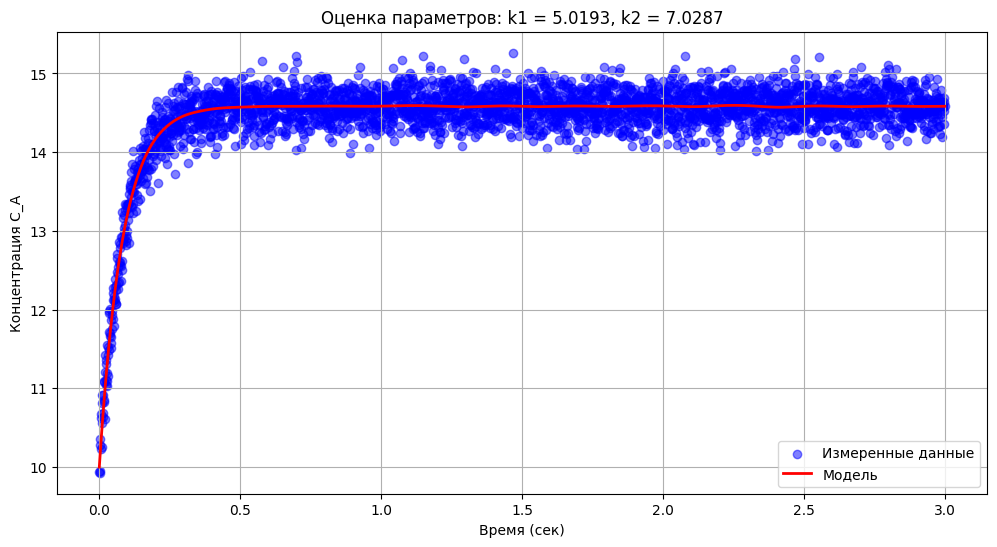

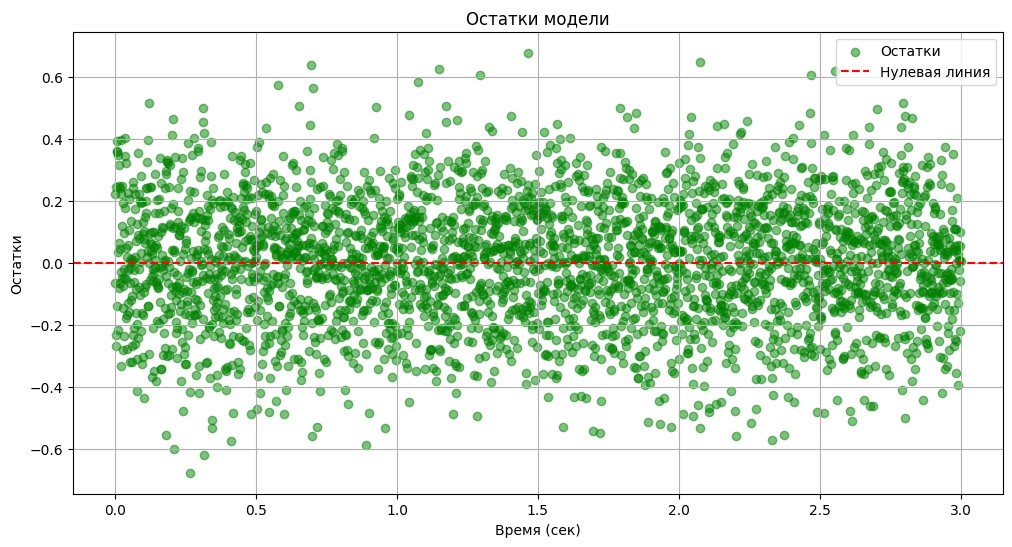

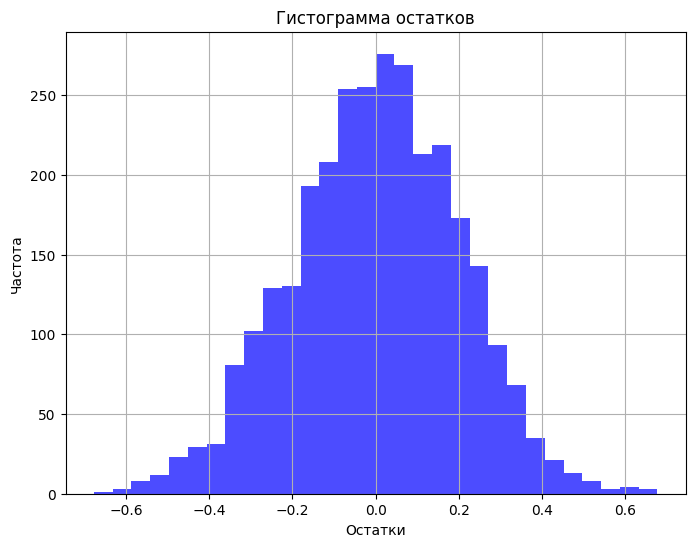

In [7]:
# Визуализация данных и модели
plt.figure(figsize=(12, 6))
plt.scatter(t, y, label='Измеренные данные', color='blue', alpha=0.5)
plt.plot(t, C_A_pred, label='Модель', color='red', linewidth=2)
plt.xlabel('Время (сек)')
plt.ylabel('Концентрация C_A')
plt.title(f'Оценка параметров: k1 = {k1_est:.4f}, k2 = {k2_est:.4f}')
plt.legend()
plt.grid()
plt.show()

# Анализ остатков
residuals = y - C_A_pred
plt.figure(figsize=(12, 6))
plt.scatter(t, residuals, label='Остатки', color='green', alpha=0.5)
plt.axhline(0, color='red', linestyle='--', label='Нулевая линия')
plt.xlabel('Время (сек)')
plt.ylabel('Остатки')
plt.title('Остатки модели')
plt.legend()
plt.grid()
plt.show()

# Гистограмма остатков
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.grid()
plt.show()

### Задание 2

Рассматривается латентное размещение Дирихле (LDA - Latent Dirichlet Allocation) - вероятностная модель порождения текста, предназначенная для описания текстов с точки зрения их тематик. При этом тема рассматривается как некоторое распределение вероятностей в пространстве слов из общего словаря [1]. Используемые в дальнейшем обозначения приведены в табл. 1.
Модель LDA задается следующим образом:
$$
\begin{aligned}
& p(\mathbf{W}, \mathbf{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi} \mid \alpha, \beta)=\prod_{t=1}^T p\left(\boldsymbol{\phi}_t \mid \beta\right) \prod_{d=1}^D p\left(\boldsymbol{\theta}_d \mid \alpha\right) \prod_{n=1}^{N_d} p\left(w_{d, n} \mid z_{d, n}, \boldsymbol{\Phi}\right) p\left(z_{d, n} \mid \boldsymbol{\theta}_d\right), \\
& p\left(\boldsymbol{\phi}_t \mid \beta\right)=\operatorname{Dir}\left(\boldsymbol{\phi}_t \mid \beta\right), \quad p\left(\boldsymbol{\theta}_d \mid \alpha\right)=\operatorname{Dir}\left(\boldsymbol{\theta}_d \mid \alpha\right) \\
& p\left(w_{d, n} \mid z_{d, n}, \boldsymbol{\Phi}\right)=\boldsymbol{\Phi}_{z_{d, n}, w_{d, n}}, \quad p\left(z_{d, n} \mid \boldsymbol{\theta}_d\right)=\boldsymbol{\Theta}_{d, z_{d, n}}
\end{aligned}
$$  
  
Таблица 1: Основные обозначения  
$$
\begin{aligned}
& w \in\{1, \ldots, W\} - номер\ слова\ в\ словаре \\
& t \in\{1, \ldots, T\} - номер\ темы\\
& N_d - число\ слов\ в\ документе\ d  \\
& \mathbf{w}_d=\left[w_{d, 1}, \ldots, w_{d, N_d}\right] - слова\ в\ документе\ d, w_{d, n} \in\{1, \ldots, W\} \\
& \mathbf{z}_d=\left[z_{d, 1}, \ldots, z_{d, N_d}\right] - темы\ документа\ d, z_{d, n} \in\{1, \ldots, T\} \\
& \boldsymbol{\theta}_d=\left[\theta_{d, 1}, \ldots, \theta_{d, T}\right] - вероятности\ тем\ в\ документе\ d \\
& \boldsymbol{\phi}_t=\left[\phi_{t, 1}, \ldots, \phi_{t, W}\right] - вероятности\ слов\ в\ теме\ t \\
& \boldsymbol{\Theta}=\left[\boldsymbol{\theta}_1, \ldots, \boldsymbol{\theta}_d\right]^T \in \mathbb{R}^{D \times T} - вероятности\ тем\ во\ всех\ документах \\
& \mathbf{\Phi}=\left[\boldsymbol{\phi}_1, \ldots, \boldsymbol{\phi}_T\right]^T \in \mathbb{R}^{T \times W} - вероятности\ слов\ во\ всех\ темах \\
& \mathbf{W}=\left\{\mathbf{w}_1, \ldots, \mathbf{w}_D\right\} - набор\ всех\ слов\ в\ корпусе \\
& \mathbf{Z}=\left\{\mathbf{z}_1, \ldots, \mathbf{z}_D\right\} - разбиение\ всех\ слов\ по\ темам
\end{aligned}
$$

где $\operatorname{Dir}(\cdot \mid \gamma)$ означает распределение Дирихле. Требуется реализовать схему Гиббса для маргинального распределения $p(\mathbf{Z} \mid \mathbf{W}, \alpha, \beta)$ (так называемый collapsed Gibbs sampling, см. [1, [2, 3]).
В файлах 'test1.dat' и 'test2.dat' записаны данные в виде таблицы: первый столбец - номер документа, второй столбец - номер слова из словаря, третий столбец сколько раз текущее слово встречается в данном документе. Для первого тестового примера задать следующие значения параметров: $T=3 ; \alpha=1 ; \beta=1$; для второго примера: $T=20 ; \alpha=0.1 ; \beta=0.1$.

In [27]:
import numpy as np
from numba import njit 


def load_data(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            d, w, count = map(int, line.strip().split())
            data.extend([(d-1, w-1)] * count)
    return np.array(data, dtype=np.int32)

def initialize(data, T):
    Z = [np.random.randint(0, T) for _ in range(len(data))]
    return Z


@njit
def gibbs_sampling(data, T, alpha, beta, num_iterations):
    # Определяем количество документов и слов
    D = np.max(data[:, 0]) + 1  # Количество документов
    W = np.max(data[:, 1]) + 1   # Количество слов в словаре
    N = data.shape[0]            # Общее количество слов в корпусе
    
    # Инициализация
    Z = np.random.randint(0, T, size=N)  # Случайные темы для каждого слова
    n_dt = np.zeros((D, T))  # Количество слов в документе d, относящихся к теме t
    n_tw = np.zeros((T, W))  # Количество раз, когда слово w встречается в теме t
    n_d = np.zeros(D)        # Общее количество слов в документе d
    n_t = np.zeros(T)        # Общее количество слов, присвоенных теме t
    
    # Заполнение счетчиков
    for i in range(N):
        d = data[i, 0]
        w = data[i, 1]
        t = Z[i]
        n_dt[d, t] += 1
        n_tw[t, w] += 1
        n_d[d] += 1
        n_t[t] += 1
    
    # Итерации Гиббса
    for iteration in range(num_iterations):
        for i in range(N):
            d = data[i, 0]
            w = data[i, 1]
            t = Z[i]
            # Уменьшаем счетчики для текущей темы
            n_dt[d, t] -= 1
            n_tw[t, w] -= 1
            n_d[d] -= 1
            n_t[t] -= 1
            
            # Вычисление вероятностей
            p = (n_dt[d, :] + alpha) / (n_d[d] + T * alpha) * (n_tw[:, w] + beta) / (n_t + W * beta)
            p /= p.sum()  # Нормализация
            
            # Выбор новой темы
            t_new = np.argmax(np.random.multinomial(1, p))
            Z[i] = t_new
            
            # Увеличиваем счетчики для новой темы
            n_dt[d, t_new] += 1
            n_tw[t_new, w] += 1
            n_d[d] += 1
            n_t[t_new] += 1
    
    # Оценка параметров
    Theta = (n_dt + alpha) / (n_d[:, None] + T * alpha)  # Распределение тем по документам
    Phi = (n_tw + beta) / (n_t[:, None] + W * beta)      # Распределение слов по темам
    
    return Theta, Phi

# Загрузка данных
data1 = load_data('./lab_files/test1.dat')
data2 = load_data('./lab_files/test2.dat')

# Параметры
T1, alpha1, beta1 = 3, 1, 1
T2, alpha2, beta2 = 20, 0.1, 0.1

# Запуск Гиббса
Theta1, Phi1 = gibbs_sampling(data1, T1, alpha1, beta1, num_iterations=500)
Theta2, Phi2 = gibbs_sampling(data2, T2, alpha2, beta2, num_iterations=500)

In [82]:
import matplotlib.pyplot as plt


def load_vocab(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        vocab = [line.strip() for line in f]
    return vocab


def plot_top_words_multiple(Phi, vocab, num_words=10, topics_per_plot=5):
    """Визуализация топовых слов для каждой темы с разбиением на несколько графиков."""
    num_topics = Phi.shape[0]
    num_plots = (num_topics + topics_per_plot - 1) // topics_per_plot  # Количество графиков
    
    for p in range(num_plots):
        start_topic = p * topics_per_plot
        end_topic = min((p + 1) * topics_per_plot, num_topics)
        
        fig, axes = plt.subplots(1, end_topic - start_topic, figsize=(15, 5), sharex=True)
        if end_topic - start_topic == 1:
            axes = [axes]  # Чтобы axes был списком, даже если тема одна
        
        for t in range(start_topic, end_topic):
            top_words_idx = np.argsort(Phi[t, :])[-num_words:][::-1]
            top_words = [vocab[i] for i in top_words_idx]
            weights = Phi[t, top_words_idx]
            
            ax = axes[t - start_topic]
            ax.barh(top_words, weights, color='skyblue')
            ax.set_title(f'Тема {t + 1}')
            ax.invert_yaxis()
        
        plt.tight_layout()
        plt.show()

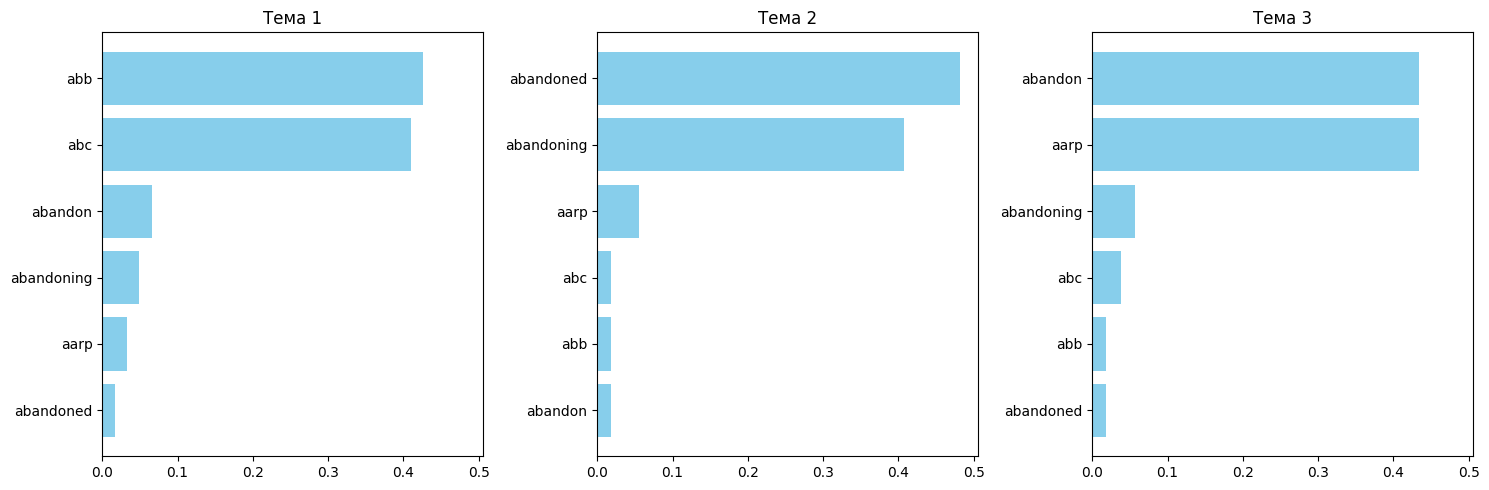

In [83]:
vocab = load_vocab('./lab_files/test2.vocab')
plot_top_words_multiple(Phi1, vocab, topics_per_plot=5)

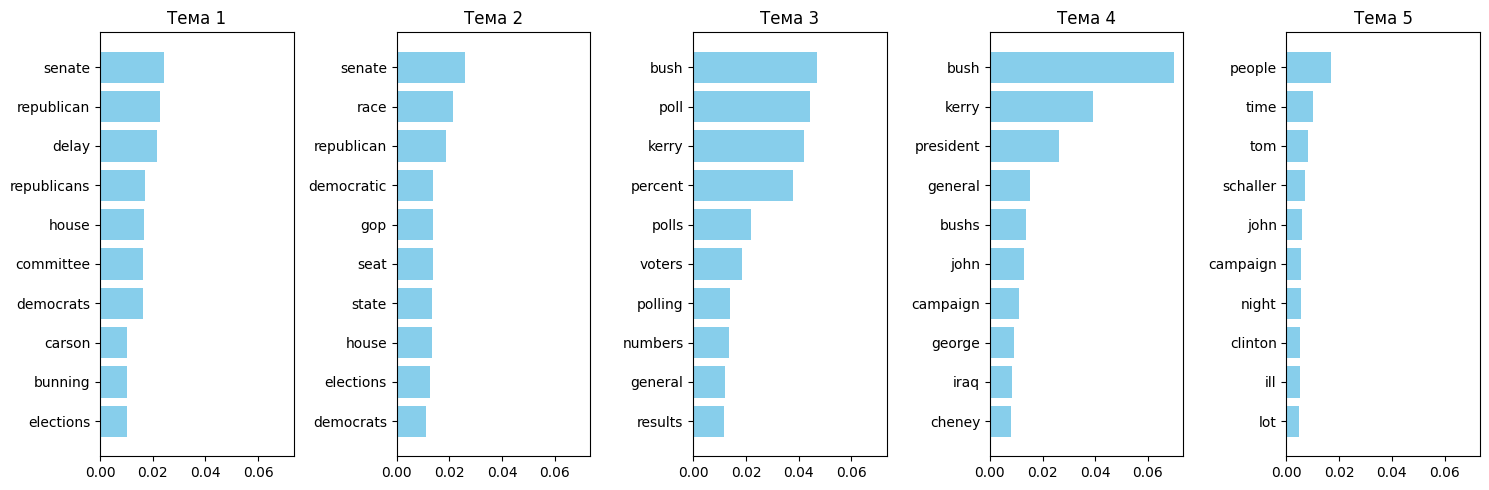

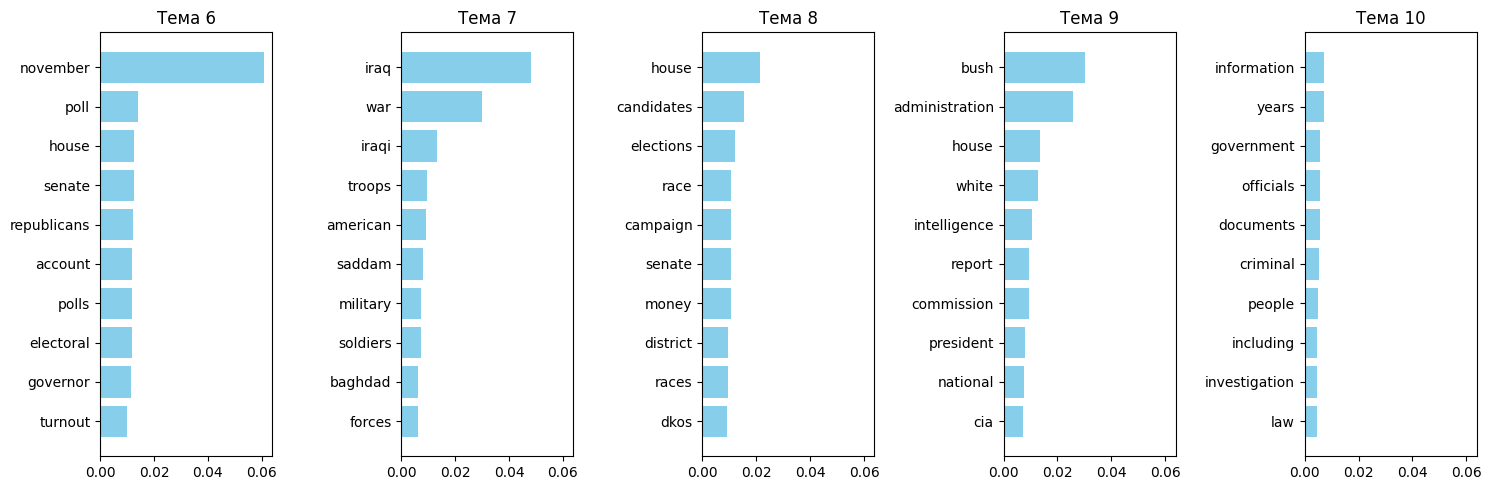

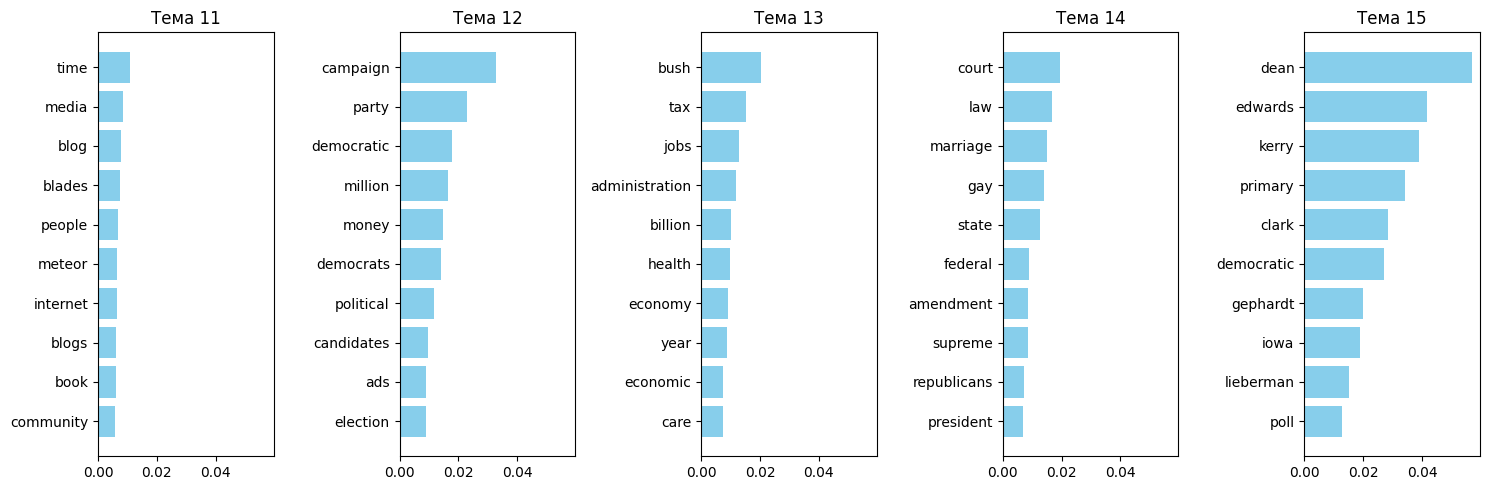

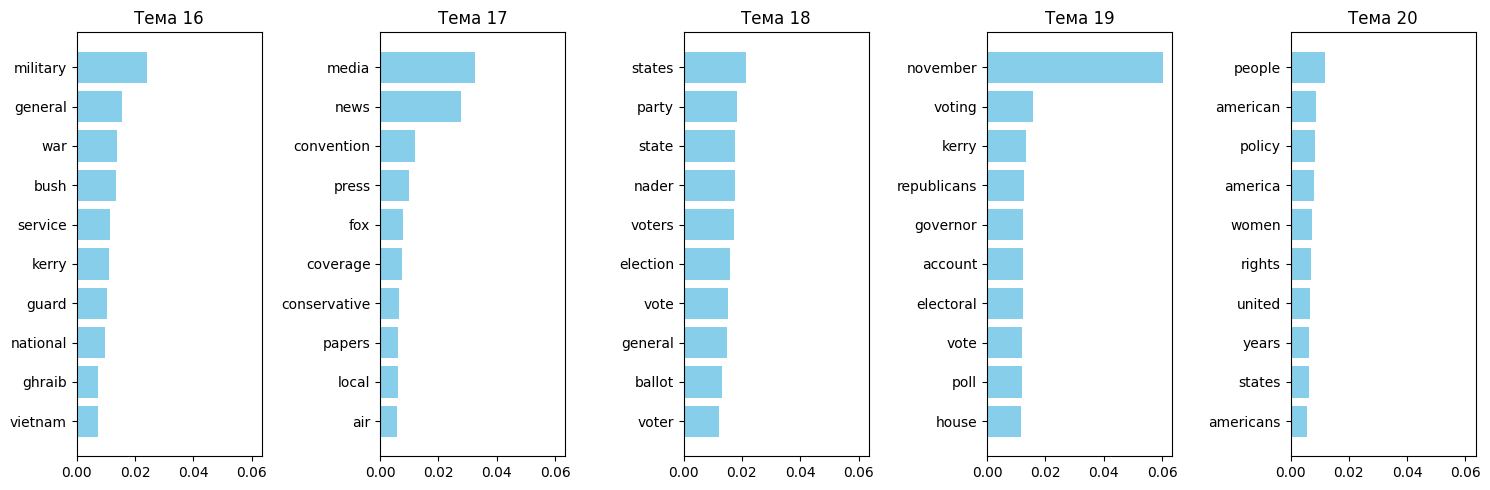

In [84]:
vocab = load_vocab('./lab_files/test2.vocab')
plot_top_words_multiple(Phi2, vocab, topics_per_plot=5)

In [94]:
import plotly.express as px
import pandas as pd

def plot_top_words_interactive(Phi, vocab, num_words=10):
    """Интерактивная визуализация топовых слов для каждой темы."""
    num_topics = Phi.shape[0]
    data = []
    
    for t in range(num_topics):
        top_words_idx = np.argsort(Phi[t, :])[-num_words:][::-1]
        top_words = [vocab[i] for i in top_words_idx]
        weights = Phi[t, top_words_idx]
        
        for word, weight in zip(top_words, weights):
            data.append({'Тема': f'Тема {t + 1}', 'Слово': word, 'Вероятность': weight})
    
    df = pd.DataFrame(data)
    fig = px.bar(df, x='Вероятность', y='Слово', color='Тема', orientation='h',
                 title='Топовые слова по темам', height=800)
    fig.show()

In [95]:
plot_top_words_interactive(Phi1, vocab)

In [96]:
plot_top_words_interactive(Phi2, vocab)

### Задание 3

Рассматривается анизотропный вариант модели Изинга на прямоугольной решетке с системой соседства первого рода, для которой распределение конфигурации $\mathrm{x}=\left(x_1, \ldots, x_n\right)\left(n-\right.$ число узлов; $\left.x_i \in\{-1,+1\}\right)$ задается следующим соотношением
$$
\pi(\mathrm{x})=\frac{1}{Z} \exp (-U(\mathrm{x}))
$$

где $Z$ - нормировочная константа (статистическая сумма), а энергия определяется следующим выражением
$$
\begin{gathered}
U(\mathbf{x})=-\beta_1 \sum_{\substack{\mathrm{i\ j} \\
}} x_i x_j-\beta_2 \sum_{\substack{\mathrm{i} \\
    \mathrm{j} \\
}} x_i x_j . \\
\end{gathered}
$$

Требуется реализовать процедуру генерации конфигураций модели с помощью методов МСМС.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets


def initialize_lattice(L, M):
    """Инициализация решетки случайными спинами."""
    return np.random.choice([-1, 1], size=(L, M))


def calculate_energy(lattice, beta1, beta2):
    """Вычисление энергии конфигурации."""
    L, M = lattice.shape
    energy = 0
    
    # Вклад от горизонтальных соседей (beta1)
    for i in range(L):
        for j in range(M - 1):
            energy -= beta1 * lattice[i, j] * lattice[i, j + 1]
    
    # Вклад от вертикальных соседей (beta2)
    for i in range(L - 1):
        for j in range(M):
            energy -= beta2 * lattice[i, j] * lattice[i + 1, j]
    
    return energy


def metropolis_step(lattice, beta1, beta2):
    """Один шаг алгоритма Метрополиса."""
    L, M = lattice.shape
    for i in range(L):
        for j in range(M):
            # Предложим новое значение спина
            proposed_spin = -lattice[i, j]
            
            # Вычислим изменение энергии
            delta_energy = 0
            
            # Горизонтальные соседи
            if j > 0:
                delta_energy += beta1 * lattice[i, j - 1]
            if j < M - 1:
                delta_energy += beta1 * lattice[i, j + 1]
            
            # Вертикальные соседи
            if i > 0:
                delta_energy += beta2 * lattice[i - 1, j]
            if i < L - 1:
                delta_energy += beta2 * lattice[i + 1, j]
            
            delta_energy *= 2 * lattice[i, j]  # Учитываем текущий спин
            
            # Примем или отклоним изменение
            if delta_energy < 0 or np.random.rand() < np.exp(-delta_energy):
                lattice[i, j] = proposed_spin


def run_mcmc(lattice, beta1, beta2, num_steps):
    """Запуск MCMC с визуализацией энергии и состояния решётки"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    img = ax1.imshow(lattice, cmap='binary', vmin=-1, vmax=1)
    plt.colorbar(img, ax=ax1)
    title = ax1.set_title('Модель Изинга: шаг 0')
    
    energy_history = []
    energy = calculate_energy(lattice, beta1, beta2)
    energy_history.append(energy)
    
    line, = ax2.plot(energy_history)
    ax2.set_title('Энергия системы')
    ax2.set_xlabel('Шаг')
    ax2.set_ylabel('Энергия')
    
    # Отображение графика
    display(fig)
    
    for step in range(num_steps):
        metropolis_step(lattice, beta1, beta2)
        
        # Обновление графика
        img.set_data(lattice)
        title.set_text(f'Модель Изинга: шаг {step + 1}')
        
        # Вычисление энергии
        energy = calculate_energy(lattice, beta1, beta2)
        energy_history.append(energy)
        line.set_data(range(step + 2), energy_history)
        ax2.relim()
        ax2.autoscale_view()
        
        # Очистка предыдущего вывода и отображение нового графика
        if (step + 1) % 10 == 0 or step == num_steps - 1:
            clear_output(wait=True)
            display(fig)
            
            # Пауза для обновления графика
            plt.pause(0.0005)
    
    plt.close()

#### Ферромагнитное поведение (β1 = 0.5, β2 = 0.5)
Формируются крупные домены с одинаковыми спинами.

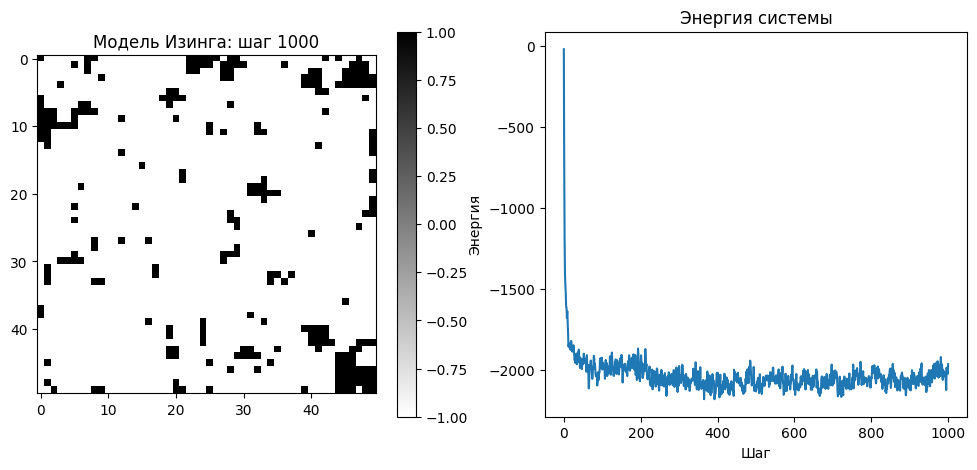

In [2]:
# Параметры
L = 50  # Размер решетки по горизонтали
M = 50  # Размер решетки по вертикали
beta1 = 0.5  # Параметр для горизонтальных связей
beta2 = 0.5  # Параметр для вертикальных связей
num_steps = 1000  # Количество шагов MCMC

# Инициализация решетки
lattice = initialize_lattice(L, M)

# Запуск MCMC с визуализацией
run_mcmc(lattice, beta1, beta2, num_steps)

#### Антиферромагнитное поведение (β1 = -0.5, β2 = -0.5)
Спины стремятся анти-выровняться, образуя шахматный паттерн.

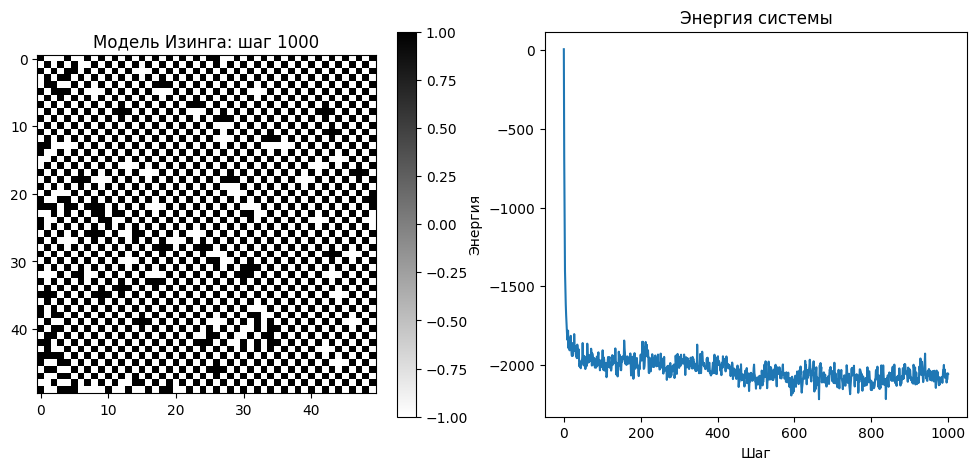

In [3]:
# Параметры
L = 50  # Размер решетки по горизонтали
M = 50  # Размер решетки по вертикали
beta1 = -0.5  # Параметр для горизонтальных связей
beta2 = -0.5  # Параметр для вертикальных связей
num_steps = 1000  # Количество шагов MCMC

# Инициализация решетки
lattice = initialize_lattice(L, M)

# Запуск MCMC с визуализацией
run_mcmc(lattice, beta1, beta2, num_steps)

#### Высокая температура (β1 = 0.1, β2 = 0.1)
Решетка остается "шумной", так как взаимодействие слабое.

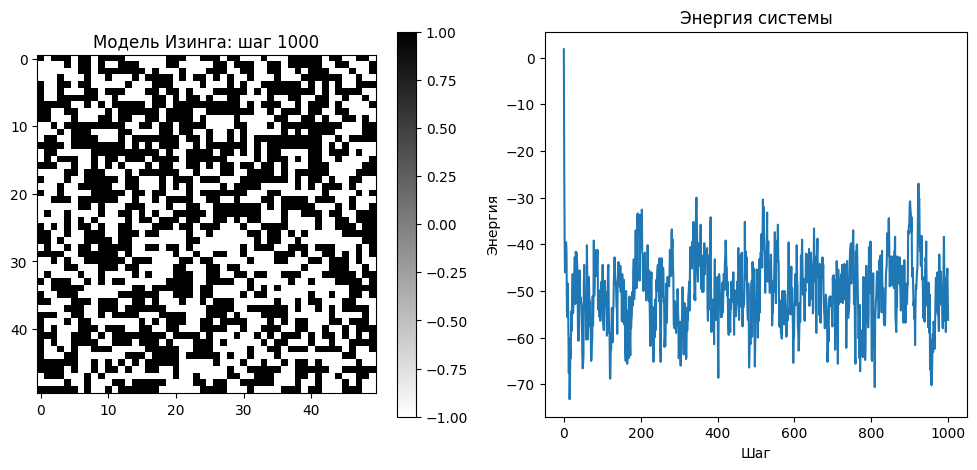

In [4]:
# Параметры
L = 50  # Размер решетки по горизонтали
M = 50  # Размер решетки по вертикали
beta1 = 0.1  # Параметр для горизонтальных связей
beta2 = 0.1  # Параметр для вертикальных связей
num_steps = 1000  # Количество шагов MCMC

# Инициализация решетки
lattice = initialize_lattice(L, M)

# Запуск MCMC с визуализацией
run_mcmc(lattice, beta1, beta2, num_steps)